In [13]:
# Imports
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from datetime import timedelta, datetime

from utils import run_sequence_plot

In [14]:
%matplotlib inline

matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.figsize'] = 15, 5

import warnings
warnings.filterwarnings('ignore')

<a id='section_1'></a>

## Section 1. Inspect Dataset

In [15]:
df = pd.read_csv(os.path.join('..', 'data', 'dataset1_SolarPrediction.csv'))

In [16]:
df.head(10)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
5,1475227824,9/29/2016 12:00:00 AM,23:30:24,1.21,48,30.46,64,120.20,5.62,06:13:00,18:13:00
6,1475227519,9/29/2016 12:00:00 AM,23:25:19,1.20,49,30.46,72,112.45,6.75,06:13:00,18:13:00
7,1475227222,9/29/2016 12:00:00 AM,23:20:22,1.24,49,30.46,71,122.97,5.62,06:13:00,18:13:00
8,1475226922,9/29/2016 12:00:00 AM,23:15:22,1.23,49,30.46,80,101.18,4.50,06:13:00,18:13:00
9,1475226622,9/29/2016 12:00:00 AM,23:10:22,1.21,49,30.46,85,141.87,4.50,06:13:00,18:13:00


In [17]:
df.shape

(32686, 11)

In [18]:
df.columns

Index(['UNIXTime', 'Data', 'Time', 'Radiation', 'Temperature', 'Pressure',
       'Humidity', 'WindDirection(Degrees)', 'Speed', 'TimeSunRise',
       'TimeSunSet'],
      dtype='object')

In [19]:
df.dtypes

UNIXTime                    int64
Data                       object
Time                       object
Radiation                 float64
Temperature                 int64
Pressure                  float64
Humidity                    int64
WindDirection(Degrees)    float64
Speed                     float64
TimeSunRise                object
TimeSunSet                 object
dtype: object

In [20]:
df.describe()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,1.478047e+09,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869
std,3.005037e+06,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474
min,1.472724e+09,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000
25%,1.475546e+09,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000
50%,1.478026e+09,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000
75%,1.480480e+09,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000
max,1.483265e+09,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000


In [21]:
df.isnull().sum()

UNIXTime                  0
Data                      0
Time                      0
Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
TimeSunRise               0
TimeSunSet                0
dtype: int64

# Exploratory Data Analysis (EDA)

## Feature Correlation

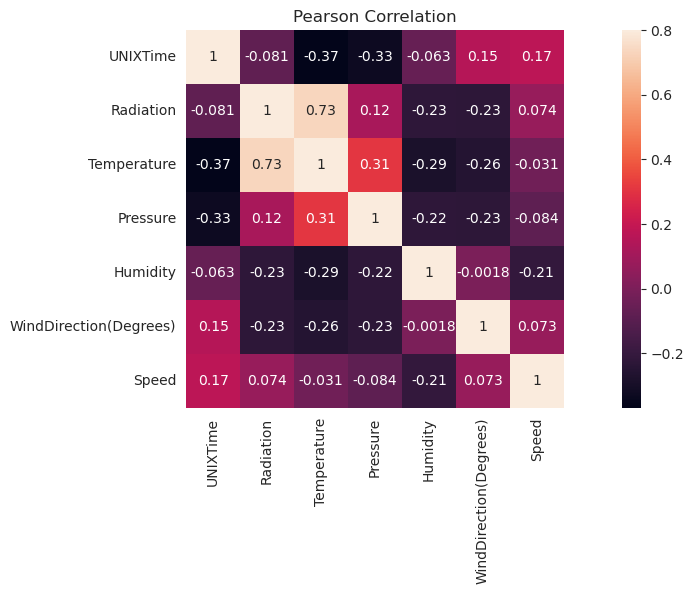

<Figure size 1200x900 with 0 Axes>

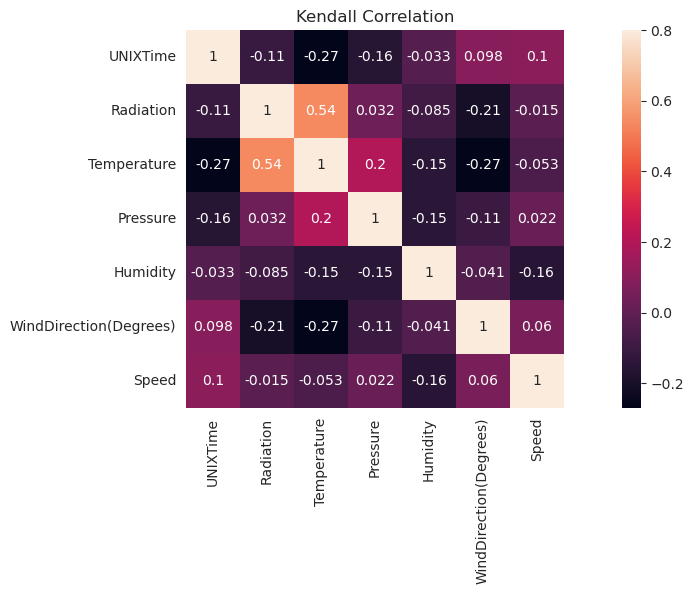

<Figure size 1200x900 with 0 Axes>

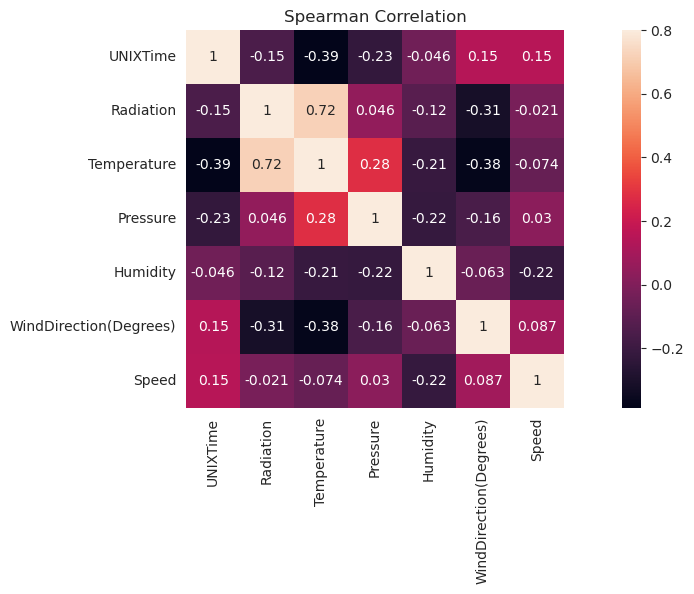

<Figure size 1200x900 with 0 Axes>

In [22]:
for method in ['pearson', 'kendall', 'spearman']:
    # Correlation matrix
    corrmat = df.corr(method=method)

    # Plot the heatmap of a correlation matrix
    ax = plt.axes()
    fig = plt.figure(figsize=(12, 9))
    sns.heatmap(corrmat, vmax=.8, ax=ax, square=True, annot=True)
    ax.set_title(f'{method.capitalize()} Correlation')
    plt.show()

As we can see, the main features here that correlate with `Radiation` are:
- `Temperature`
- `Humidity`
- `Wind Direction`

But here, we didn't take advantage of `TimeSunRise` and `TimeSunSet` features. So we might want take those into account.

Now we can look at how features correlate between themselves to try to create a feature that will utilize that information.

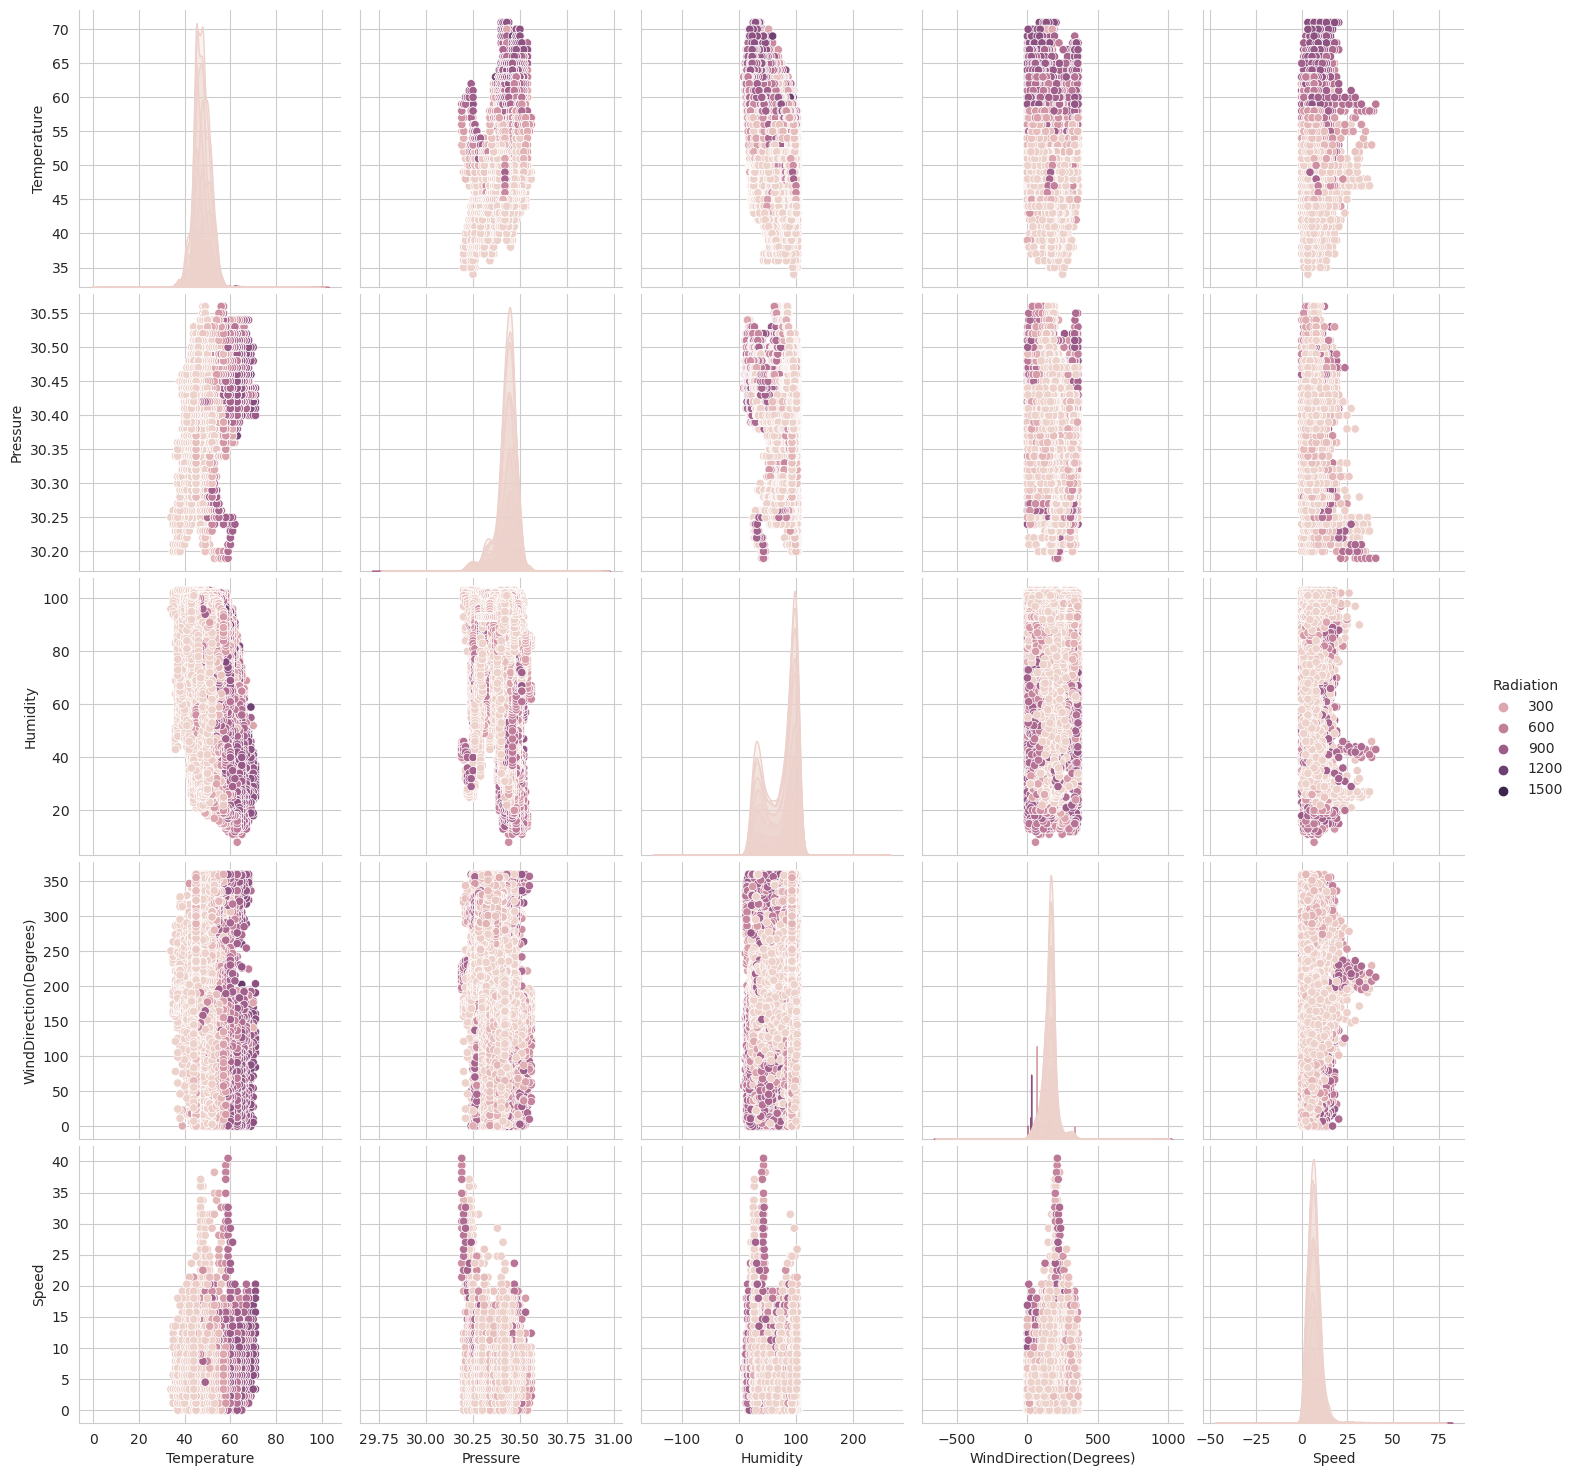

In [23]:
# Include only the columns that have sufficient correlation with the 'Outcome'.
cols = ["Temperature", "Pressure", "Humidity", "WindDirection(Degrees)", "Speed", "Radiation"]
# Plot the relationship between all features using 'Outcome' as a visual metric.
sns.pairplot(df[cols], height=3.0, hue="Radiation")

As we can see, there is not really much we can do to separate the samples just because we have the records taken during day and night time, which is alright when we are doing the forecasting.

## Feature Engineering
Given `TimeSunRise` and `TimeSunSet` features, we can try take advantage of them by calculating the approximate sun position deviation from zenith. We are interested in this because sun emits the most amount of radiation when being in zenith.

In [24]:
def to_timedelta(time_str):
    """
    Convert string formatted time to timedelta.

    :param time_str: str - Time in format "HH:MM:SS".
    :return: timedelta
    """
    time = time_str.split(":")
    return timedelta(hours=int(time[0]), minutes=int(time[1]))


def current_zenith_deviation(row):
    """
    Given sunrise and sunset time, calculate approximate zenith time and
    subtract it from the current time to get approximate zenith deviation time.

    :param row: list - Row(TimeSunRise, TimeSunSet, Time)
    :return: float - Zenith deviation in minutes.
    """
    sunrise_time, sunset_time, current_time = row[0], row[1], row[2]
    
    # Convert to timedelta.
    sunrise_td, sunset_td = to_timedelta(sunrise_time), to_timedelta(sunset_time)
    current_td = to_timedelta(current_time)

    # Get approximate sun zenith time.
    approximate_zenith_td = sunrise_td + (sunset_td - sunrise_td) / 2

    # Get current time deviation from time the sun is in zenith.
    if approximate_zenith_td > current_td:
        zenith_time_deviation = approximate_zenith_td - current_td
    else:
        zenith_time_deviation = current_td - approximate_zenith_td

    # Return zenith deviation in minutes.
    return zenith_time_deviation.total_seconds() // 60

In [25]:
df["ZenithDeviation"] = df[["TimeSunRise", 	"TimeSunSet", "Time"]].apply(current_zenith_deviation,  axis=1)

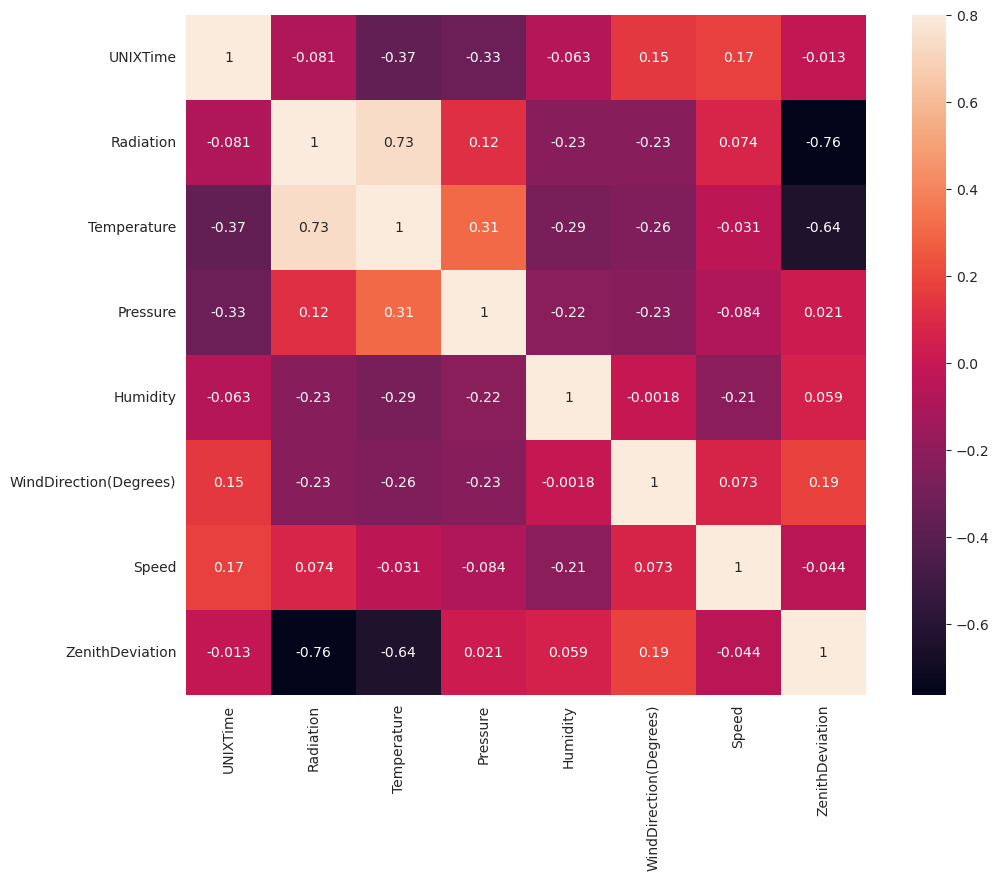

In [26]:
# Correlation matrix
corrmat = df.corr()

# Plot the heatmap of a correlation matrix
fig = plt.figure(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True)
plt.show()

As we can see, `Zenith Deviation` has now the biggest correlation with `Radiation` and `Temperature`.

Apart from that, we also want to add some time features for the future forecasting.

## Data Preprocessing

In [27]:
df["DateTime"] = pd.to_datetime(df['UNIXTime'], unit='s') - timedelta(hours=10)  # include timezone shift

In [28]:
df['Year'] = df.DateTime.dt.year
df['Month'] = df.DateTime.dt.month
df['Day'] = df.DateTime.dt.day
df['Hour'] = df.DateTime.dt.hour

In [29]:
df['Hourly_DateTime'] = pd.to_datetime(dict(year=df.Year, month=df.Month, day=df.Day, hour=df.Hour))

# Drop now unnecessary columns.
df = df.drop(['UNIXTime', 'Data', 'Time', 'TimeSunRise', 'TimeSunSet'], axis=1)

In [30]:
print(f'Data time range: from {df.DateTime.unique().min()} to {df.DateTime.unique().max()}')

Data time range: from 2016-09-01T00:00:08.000000000 to 2016-12-31T23:55:01.000000000


In [31]:
def set_column_types_to_int(df, column_names):
    for col_name in column_names:
        df[col_name] = df[col_name].astype(int)

# Here we take mean of radiation for each hour, since a number of measures during hour can be different for some days what is bad for sum().
# Secondly, sum of radiation is not accurate sum for radiation during each hour
hourly_radiation_df = df.groupby(['Hourly_DateTime']).mean().copy()
hourly_radiation_df['Log_Radiation'] = np.log(df.groupby(['Hourly_DateTime'])['Radiation'].mean().copy())
set_column_types_to_int(hourly_radiation_df, ['Year', 'Month', 'Day', 'Hour'])
hourly_radiation_df.head(20)

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,ZenithDeviation,Year,Month,Day,Hour,Log_Radiation
Hourly_DateTime,,,,,,,,,,,,
2016-09-01 00:00:00,2.288750,51.125000,30.430000,103.000000,109.837500,8.857500,713.250000,2016,9,1,0,0.828006
2016-09-01 01:00:00,2.943333,51.500000,30.417500,103.000000,121.345833,5.246667,654.500000,2016,9,1,1,1.079543
2016-09-01 02:00:00,2.733333,51.000000,30.404167,103.000000,136.402500,9.653333,594.500000,2016,9,1,2,1.005522
2016-09-01 03:00:00,2.344545,50.818182,30.400000,102.636364,89.257273,5.520909,532.000000,2016,9,1,3,0.852092
2016-09-01 04:00:00,2.607500,49.083333,30.407500,102.000000,118.165833,7.965833,474.500000,2016,9,1,4,0.958392
2016-09-01 05:00:00,1.769000,49.000000,30.412000,97.100000,144.625000,8.435000,418.000000,2016,9,1,5,0.570414
2016-09-01 06:00:00,23.375000,48.900000,30.414000,77.900000,138.292000,8.211000,357.500000,2016,9,1,6,3.151667
2016-09-01 07:00:00,120.567778,50.222222,30.430000,85.333333,108.943333,6.873333,296.444444,2016,9,1,7,4.792212
2016-09-01 08:00:00,464.377500,52.875000,30.450000,80.750000,117.403750,7.450000,233.875000,2016,9,1,8,6.140698


### Make sure our timeseries is continuous

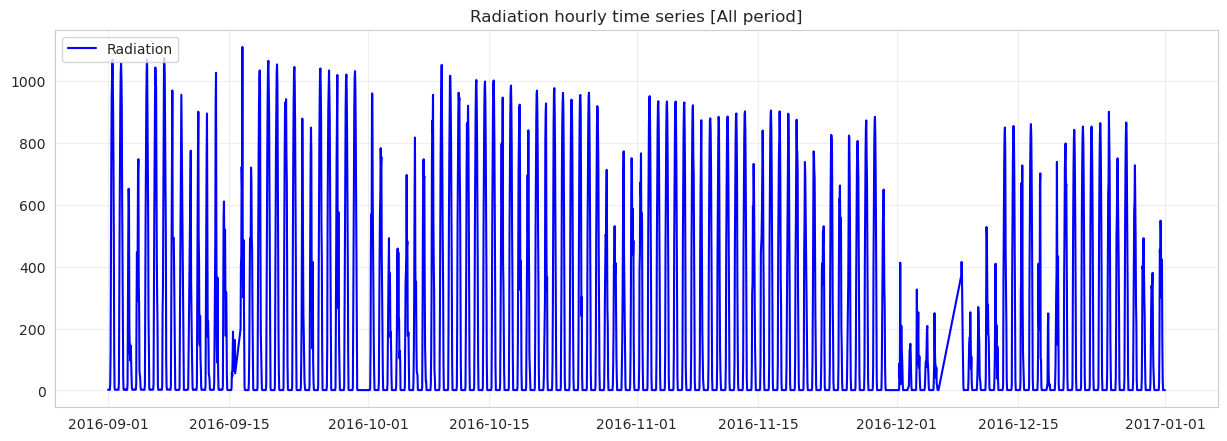

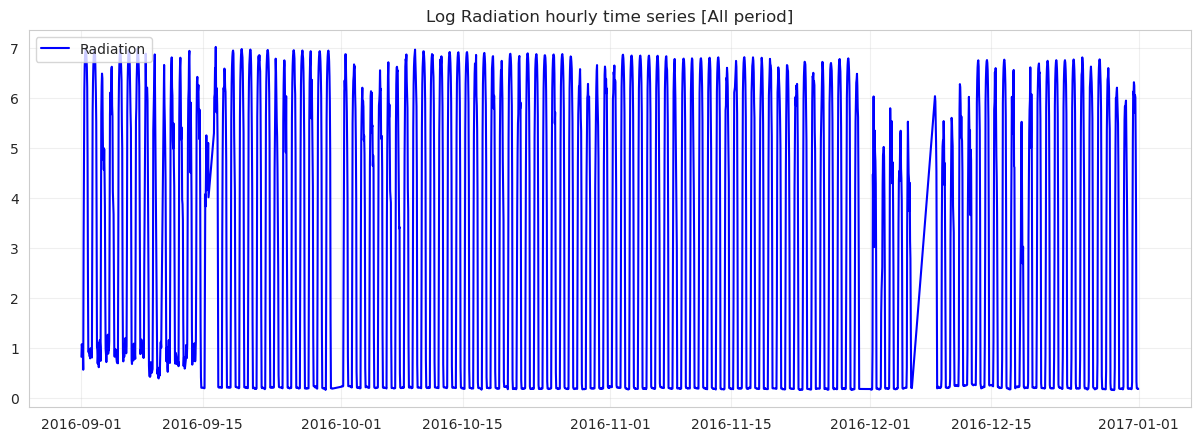

In [32]:
run_sequence_plot(hourly_radiation_df, 'Radiation', 'Radiation hourly time series [All period]')
run_sequence_plot(hourly_radiation_df, 'Log_Radiation', 'Log Radiation hourly time series [All period]')

From above plots we can conclude that period from 2016-10-01 to 2016-11-29 is continuous. That's why we will forecast based on it to achieve better accuracy than on time seties with missed values for several days.

In [33]:
hourly_radiation_df = hourly_radiation_df[datetime(2016, 10, 1, 0, 0, 0): datetime(2016, 11, 29, 0, 0, 0)]
hourly_radiation_df = hourly_radiation_df.sort_index(ascending=True)  # just to be sure sort index in ascending order

## Save Data

In [34]:
hourly_radiation_df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,ZenithDeviation,Year,Month,Day,Hour,Log_Radiation
Hourly_DateTime,,,,,,,,,,,,
2016-10-01 00:00:00,1.260000,48.500000,30.452500,88.250000,153.245000,9.981250,697.625,2016,10,1,0,0.231112
2016-10-01 01:00:00,1.272500,50.416667,30.443333,98.916667,145.180000,8.060000,644.500,2016,10,1,1,0.240983
2016-10-01 02:00:00,1.276667,50.083333,30.431667,100.000000,136.536667,6.841667,584.500,2016,10,1,2,0.244253
2016-10-01 03:00:00,1.272500,50.166667,30.430000,100.000000,132.098333,5.343333,524.500,2016,10,1,3,0.240983
2016-10-01 04:00:00,1.267500,50.166667,30.431667,100.166667,117.016667,6.746667,464.500,2016,10,1,4,0.237046


In [98]:
hourly_radiation_df.to_csv(os.path.join('..', 'data', 'dataset1_HourlySolarRadiationProcessed.csv'),
                           sep=",", columns=hourly_radiation_df.columns, float_format="%.2f")